# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [0]:
a=[]
while(1):
  a.append('1')


### Import the necessary libraries

In [0]:
import tensorflow as tf
import os
import urllib, tarfile

from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from keras.applications.mobilenet import preprocess_input, MobileNet
from keras.layers import Conv2D,Reshape
from keras.models import Model
from keras import metrics
from keras.backend import epsilon
import matplotlib.pylab as plt

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change directory

In [0]:
os.chdir= './My Drive/AIML/ACV1/Lab12Jan_Racoon/'  #change dir to  project folder

In [25]:
!ls -l

total 12
drwx------ 4 root root 4096 Jan 12 04:06 drive
drwxr-xr-x 7 root root 4096 Jan 12 04:08 models
drwxr-xr-x 1 root root 4096 Dec 18 16:52 sample_data


In [0]:
#!pip install patool
import patoolib
#patoolib.extract_archive("images_racoon-1.rar", outdir="/content/drive/My Drive/AIML/ACV1/Lab12Jan_Racoon")

In [27]:
!ls -l

total 12
drwx------ 4 root root 4096 Jan 12 04:06 drive
drwxr-xr-x 7 root root 4096 Jan 12 04:08 models
drwxr-xr-x 1 root root 4096 Dec 18 16:52 sample_data


### Load the training data from train.csv file

In [0]:
#Read csv file as pandas dataframe, csv file has no header
train_df = pd.read_csv('/content/drive/My Drive/AIML/ACV1/Lab12Jan_Racoon/train_labels.csv', header=None, 
                       names=['filename','width','height','class','xmin','ymin','xmax','ymax'])

In [0]:
#Read csv file as pandas dataframe, csv file has no header
#train_df = pd.read_csv('train_labels.csv', header=None, 
 #                      names=['filename','width','height','class','xmin','ymin','xmax','ymax'])

### Print the shape of the train dataset

In [29]:
print(train_df.shape)
train_df.head()

(174, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,filename,width,height,class,xmin,ymin,xmax,ymax
1,raccoon-17.jpg,259,194,raccoon,95,60,167,118
2,raccoon-11.jpg,660,432,raccoon,3,1,461,431
3,raccoon-63.jpg,600,400,raccoon,74,107,280,290
4,raccoon-63.jpg,600,400,raccoon,227,93,403,298


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in individual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open('/content/drive/My Drive/AIML/ACV1/Lab12Jan_Racoon/train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

In [33]:
len(paths)

173

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
from PIL import Image, ImageFile

In [0]:
batch_images=np.zeros((len(paths),IMAGE_SIZE,IMAGE_SIZE,3),dtype=np.float32)


In [0]:
for i, x in enumerate(paths):
 img=Image.open('/content/drive/My Drive/AIML/ACV1/Lab12Jan_Racoon/images/'+x)
 img=img.resize((IMAGE_SIZE,IMAGE_SIZE))
 img=img.convert('RGB')
 batch_images[i]=preprocess_input(np.array(img,dtype=np.float32))

In [37]:
img.size

(128, 128)

In [38]:
batch_images[0]

array([[[-0.18431371, -0.01176471, -0.10588235],
        [-0.9764706 , -0.8509804 , -0.92941177],
        [-0.92941177, -0.88235295, -0.9137255 ],
        ...,
        [ 0.17647064,  0.654902  ,  0.12941182],
        [-0.1607843 ,  0.2941177 , -0.02745098],
        [ 0.3411765 ,  0.7411765 ,  0.48235297]],

       [[-0.54509807, -0.38823527, -0.47450978],
        [-0.9843137 , -0.88235295, -0.9372549 ],
        [-0.827451  , -0.79607844, -0.8039216 ],
        ...,
        [-0.27058822,  0.18431377, -0.27843136],
        [-0.19215685,  0.26274514, -0.19215685],
        [ 0.0196079 ,  0.37254906,  0.12941182]],

       [[-0.7490196 , -0.62352943, -0.7019608 ],
        [-0.84313726, -0.75686276, -0.8039216 ],
        [-0.8352941 , -0.8039216 , -0.8117647 ],
        ...,
        [-0.32549018,  0.12156868, -0.4352941 ],
        [-0.25490195,  0.22352946, -0.5058824 ],
        [-0.17647058,  0.1686275 , -0.11372548]],

       ...,

       [[ 0.01176476,  0.33333337, -0.19999999],
        [-0

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [39]:
#Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3
model=MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,alpha=1.0)
#Freeze all layers of Pre-trained model
len(model.layers)
for layer in model.layers:
    layer.trainable = False
#Add convolution and reshape layers at the end to ensure the output is 4 coordinates
x=model.layers[-1].output
x=Conv2D(4,kernel_size=4,name='coords')(x)
x=Reshape((4,))(x)

model=Model(inputs=model.input, output=x)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  # This is added back by InteractiveShellApp.init_path()


In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

In [48]:
IoU

<function __main__.IoU>

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [50]:
# model.compile function
model.compile(optimizer='adam', 
                    loss=('mse'),
                    metrics=[IoU])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
#model.fit function

In [54]:
model.fit(batch_images,coords, epochs=30,batch_size = 32, verbose = 1)

Epoch 1/30
173/173 [==============================] - 3s 16ms/step - loss: 3462.5225 - IoU: 0.0830
Epoch 2/30
173/173 [==============================] - 3s 16ms/step - loss: 689.9602 - IoU: 0.4314
Epoch 3/30
173/173 [==============================] - 3s 16ms/step - loss: 463.6019 - IoU: 0.5765
Epoch 4/30
173/173 [==============================] - 3s 16ms/step - loss: 596.0833 - IoU: 0.5471
Epoch 5/30
173/173 [==============================] - 3s 15ms/step - loss: 364.7873 - IoU: 0.6082
Epoch 6/30
173/173 [==============================] - 3s 16ms/step - loss: 217.6249 - IoU: 0.6461
Epoch 7/30
173/173 [==============================] - 3s 16ms/step - loss: 212.4190 - IoU: 0.6438
Epoch 8/30
173/173 [==============================] - 3s 16ms/step - loss: 188.1065 - IoU: 0.6725
Epoch 9/30
173/173 [==============================] - 3s 16ms/step - loss: 149.0324 - IoU: 0.7184
Epoch 10/30
173/173 [==============================] - 3s 16ms/step - loss: 137.8110 - IoU: 0.7328
Epoch 11/30
173/17

In [0]:
model.save('racoon_detect.h5')

### Pick a test image from the given data

In [0]:
import cv2

In [167]:
#read image
r1=cv2.imread('/content/drive/My Drive/AIML/ACV1/Lab12Jan_Racoon/images/raccoon-96.jpg')
r1

array([[[109, 174, 195],
        [109, 172, 193],
        [133, 192, 212],
        ...,
        [ 72, 118, 152],
        [ 20,  66, 100],
        [ 97, 143, 177]],

       [[137, 191, 214],
        [115, 169, 192],
        [101, 153, 176],
        ...,
        [ 73, 119, 153],
        [ 52,  98, 132],
        [ 99, 145, 179]],

       [[131, 166, 192],
        [ 75, 112, 138],
        [ 65, 103, 127],
        ...,
        [ 89, 135, 169],
        [ 80, 126, 160],
        [ 95, 141, 175]],

       ...,

       [[ 90, 138, 166],
        [101, 149, 177],
        [105, 153, 181],
        ...,
        [ 34,  33,  37],
        [ 36,  35,  39],
        [ 38,  37,  41]],

       [[ 97, 145, 173],
        [108, 156, 184],
        [111, 159, 187],
        ...,
        [ 33,  32,  36],
        [ 36,  35,  39],
        [ 37,  36,  40]],

       [[102, 150, 178],
        [113, 161, 189],
        [117, 165, 193],
        ...,
        [ 33,  32,  36],
        [ 35,  34,  38],
        [ 37,  36,  40]]

In [168]:
r1.shape

(219, 230, 3)

In [0]:
image_height,image_width,_=r1.shape

In [170]:
image_height

219

In [171]:
image_width

230

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
r2=cv2.resize(r1,(IMAGE_SIZE,IMAGE_SIZE))

In [173]:
r2.shape

(128, 128, 3)

In [174]:
#unscaled image
r2

array([[[116, 176, 198],
        [125, 181, 202],
        [124, 173, 193],
        ...,
        [ 94, 140, 174],
        [ 76, 123, 156],
        [ 71, 117, 151]],

       [[107, 142, 168],
        [ 85, 123, 147],
        [171, 214, 235],
        ...,
        [ 61, 107, 141],
        [ 88, 134, 168],
        [ 88, 134, 168]],

       [[131, 138, 167],
        [135, 156, 181],
        [138, 180, 200],
        ...,
        [ 78, 121, 154],
        [ 81, 124, 157],
        [ 81, 124, 157]],

       ...,

       [[117, 167, 195],
        [102, 153, 181],
        [107, 159, 189],
        ...,
        [ 31,  30,  32],
        [ 31,  30,  32],
        [ 32,  31,  33]],

       [[ 94, 142, 170],
        [106, 154, 183],
        [103, 153, 183],
        ...,
        [ 29,  28,  32],
        [ 33,  32,  36],
        [ 37,  36,  40]],

       [[105, 153, 181],
        [115, 163, 191],
        [100, 150, 180],
        ...,
        [ 30,  29,  33],
        [ 33,  31,  35],
        [ 36,  35,  39]]

### Predict the coordinates of the bounding box for the given test image

In [0]:
#scaled image
r2_pp=preprocess_input(np.array(r2,dtype=np.float32))

In [176]:
r2_pp

array([[[-0.09019607,  0.3803922 ,  0.5529412 ],
        [-0.01960784,  0.41960788,  0.58431375],
        [-0.02745098,  0.35686278,  0.5137255 ],
        ...,
        [-0.26274508,  0.09803927,  0.36470592],
        [-0.40392154, -0.03529412,  0.22352946],
        [-0.44313723, -0.08235294,  0.18431377]],

       [[-0.1607843 ,  0.11372554,  0.3176471 ],
        [-0.3333333 , -0.03529412,  0.15294123],
        [ 0.3411765 ,  0.6784314 ,  0.84313726],
        ...,
        [-0.52156866, -0.1607843 ,  0.10588241],
        [-0.3098039 ,  0.05098045,  0.3176471 ],
        [-0.3098039 ,  0.05098045,  0.3176471 ]],

       [[ 0.02745104,  0.082353  ,  0.30980396],
        [ 0.05882359,  0.22352946,  0.41960788],
        [ 0.082353  ,  0.41176474,  0.5686275 ],
        ...,
        [-0.38823527, -0.05098039,  0.20784318],
        [-0.36470586, -0.02745098,  0.2313726 ],
        [-0.36470586, -0.02745098,  0.2313726 ]],

       ...,

       [[-0.08235294,  0.30980396,  0.5294118 ],
        [-0

In [0]:
region = model.predict(np.array([r2_pp]))[0]

In [178]:
region

array([ 19.299526,  13.338624, 117.08821 , 115.61782 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

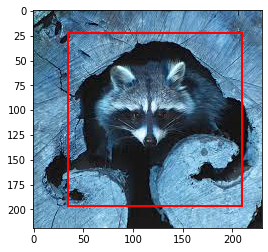

In [182]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(r1)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [0]:
#Second example
#read image
r3=cv2.imread('/content/drive/My Drive/AIML/ACV1/Lab12Jan_Racoon/images/raccoon-103.jpg')

In [254]:
r3.shape

(640, 480, 3)

In [0]:
image_height,image_width,_=r3.shape

In [256]:
image_height

640

In [257]:
image_width

480

In [258]:
r4=cv2.resize(r3,(IMAGE_SIZE,IMAGE_SIZE))
r4.shape

(128, 128, 3)

In [0]:
#scaled image
r3_pp=preprocess_input(np.array(r4,dtype=np.float32))

In [260]:
r3_pp

array([[[ 0.75686276,  0.81960785,  0.92156863],
        [ 0.5372549 ,  0.6392157 ,  0.7490196 ],
        [ 0.33333337,  0.45882356,  0.5921569 ],
        ...,
        [-0.16862744,  0.12156868,  0.3411765 ],
        [-0.36470586, -0.03529412,  0.19215691],
        [-0.40392154, -0.06666666,  0.14509809]],

       [[ 0.73333335,  0.7882353 ,  0.8901961 ],
        [ 0.6627451 ,  0.73333335,  0.8352941 ],
        [ 0.6784314 ,  0.7490196 ,  0.85882354],
        ...,
        [-0.32549018, -0.08235294,  0.14509809],
        [-0.31764704, -0.05882353,  0.14509809],
        [-0.38039213, -0.09803921,  0.09019613]],

       [[ 0.23921573,  0.34901965,  0.49803925],
        [ 0.52156866,  0.60784316,  0.7176471 ],
        [ 0.6313726 ,  0.7254902 ,  0.81960785],
        ...,
        [-0.8980392 , -0.79607844, -0.73333335],
        [-0.9372549 , -0.8352941 , -0.77254903],
        [-0.92156863, -0.81960785, -0.75686276]],

       ...,

       [[ 0.35686278,  0.33333337,  0.35686278],
        [ 0

In [261]:
region = model.predict(np.array([r3_pp]))[0]
region

array([ 26.251242,   9.204805, 122.44925 , 124.886444], dtype=float32)

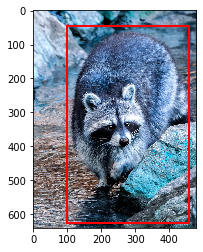

In [262]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(r3)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()